# Assignment 2: Text Classification

Text classification is a difficult task. Given a series of documents (data clouds formulated as words), we should find one of many discreet classes for that document.\
Our barriers are not only the inherent difficulty of the task, but also the endless complexities of language, like words with multiple meanings, different word formations (plurals in most languages, additional gender and verb conjugations in languages like Slovene).\
This task proves so difficult, in fact, that the only way to really approach it is to abandon handcrafted algorithms entirely and apply machine learning models. In this assigment, we will be teaching and tuning a linear regression model, a random forest classifier, and a gradient boosting method. We will also be comparing our findings to BERT, a pretrained model taught on a much larger dataset.\
We will measure the effectiveness of our models with accuracy, recall, precision, and particularly F1 score. 

## Data Preprocessing

The first thing we should do for any text learning task is to preprocess our data.
Each of our documents is a JSON object with a link, a headline, a given category, a short description of the document, and the authors who made it. We can process all of these objects into a csv file, which will shortly be interpreted as a dataset (using the Pandas library).

In [7]:
import json
import csv
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize an empty list to store processed entries
processed_data = []

# Read the JSON file and process each line
with open('News_Category_Dataset_IS_course.json', 'r') as file:
    for line in file:
        # Parse the JSON data for each line
        entry = json.loads(line)

        # Extract relevant information
        link = entry["link"]
        headline = entry["headline"]
        category = entry["category"]
        short_description = entry["short_description"]
        authors = entry["authors"]
        
        # Convert the date from milliseconds to a human-readable format
        date = entry["date"]
        formatted_date = datetime.datetime.utcfromtimestamp(date / 1000.0).strftime('%Y-%m-%d %H:%M:%S')

        # Store the processed entry in the list
        processed_entry = {
            "link": link,
            "headline": headline,
            "category": category,
            "short_description": short_description,
            "authors": authors,
            "date": formatted_date
        }
        processed_data.append(processed_entry)

# Write processed data to a CSV file
csv_file_path = 'processed_data.csv'
fieldnames = ["link", "headline", "category", "short_description", "authors", "date"]

with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Write data
    for entry in processed_data:
        writer.writerow(entry)

In [8]:
import pandas as pd

# Read CSV file into a Pandas DataFrame
df = pd.read_csv('processed_data.csv')
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23 00:00:00
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23 00:00:00
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20 00:00:00
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",NaN,2022-09-20 00:00:00
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,NaN,2022-09-19 00:00:00
...,...,...,...,...,...,...
148117,https://www.huffingtonpost.com/entry/girl-with...,'Girl With the Dragon Tattoo' India Release Ca...,ENTERTAINMENT,"""Sony Pictures will not be releasing The Girl ...",NaN,2012-01-28 00:00:00
148118,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",NaN,2012-01-28 00:00:00
148119,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",NaN,2012-01-28 00:00:00
148120,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,NaN,2012-01-28 00:00:00


In [9]:
df.describe()

,link,headline,category,short_description,authors,date
count,148122,147388,148122,135938,123706,148122
unique,148096,146295,15,133792,19633,3618
top,https://www.huffingtonpost.comhttp://www.newre...,Sunday Roundup,POLITICS,Welcome to the HuffPost Rise Morning Newsbrief...,Lee Moran,2014-11-05 00:00:00
freq,2,90,35602,191,2058,98


We can use a grouping and sum on our dataframe to find out how man of each category we initially see. Diving this by the sum gives us the percentage of each category in the dataset, we can then sort these values to find which categories are the most common.

In [10]:
(df.groupby('category')["short_description"].count() / sum(df.groupby('category')["short_description"].count())).sort_values(ascending=False)

category
POLITICS          0.237336
WELLNESS          0.131369
ENTERTAINMENT     0.108138
STYLE & BEAUTY    0.071783
TRAVEL            0.069002
PARENTING         0.064346
FOOD & DRINK      0.046308
QUEER VOICES      0.041019
HEALTHY LIVING    0.038554
BUSINESS          0.037583
COMEDY            0.034016
SPORTS            0.032331
HOME & LIVING     0.031595
BLACK VOICES      0.030558
PARENTS           0.026063
Name: short_description, dtype: float64

We should also find out which data entries are missing from our dataset and decide what we will do with this data.\
We will not remove the data that has missing short_description and author, since they make up a large part.

In [11]:
# Check for missing data in each column
missing_data = df.isnull().sum()

# Print the count of missing values for each column
print("Missing Data Summary:")
print(missing_data)

Missing Data Summary:
link                     0
headline               734
category                 0
short_description    12184
authors              24416
date                     0
dtype: int64


We can check which types our columns have, then convert them to strings as the final step of our preprocessing.

In [12]:
# Check the dta types of columns
df.dtypes

link                 object
headline             object
category             object
short_description    object
authors              object
date                 object
dtype: object

In [13]:
# Convert everything but date to string
df['link'] = df['link'].astype("string")
df['headline'] = df['headline'].astype("string")
df['category'] = df['category'].astype("string")
df['short_description'] = df['short_description'].astype("string")
df['authors'] = df['authors'].astype("string")

## Tokenization

The next step in the process is to turn our text into tokens using the Natural Language ToolKit library. We need to do this so each word will only have one form, rather than two, three, or the 30+ we would encounter in languages like Slovene.\
Luckily for us, NLTK already includes all the tools we need, like a lemmatizer and a stemmer.\
We will convert our text to lowercase, make sure to remove English stopwords, like "a" and "the", and remove numbers.


In [14]:
#%pip install nltk

In [15]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Download necessary resources (if not already downloaded)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [16]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Stemming (uncomment if you want to use stemming)
    stemmed_words = [stemmer.stem(word) for word in words]

    # Join the words back into a string
    preprocessed_text = ' '.join(lemmatized_words)
    return preprocessed_text

We should also process links, as the site we got the article from most likely won't tell us much about the document.

In [17]:
# Function to preprocess links (remove everything up to /entry/ and remove the '-' characters)
def preprocess_link(link):
    # Remove everything up to /entry/ if it exists
    if '/entry/' in link:
        link = link.split('/entry/')[1]
    
    #Remove everything after the first '_' character if it exists
    if '_' in link:
        link = link.split('_')[0]

    # Remove the '-' characters if they exist
    if '-' in link:
        link = link.replace('-', ' ')

    #preprocess the link text
    link = preprocess_text(link)
    return link

In [18]:
#Apply the preprocessing function to the headline column only in rows where the headline isn't missing

df.loc[df['headline'].notnull(), 'headline'] = df.loc[df['headline'].notnull(), 'headline'].apply(preprocess_text)

In [19]:
#Apply the preprocessing to short_description and links as well
df.loc[df['short_description'].notnull(), 'short_description'] = df.loc[df['short_description'].notnull(), 'short_description'].apply(preprocess_text)

In [20]:
#Preprocess the authors where the authors aren't missing
df.loc[df['authors'].notnull(), 'authors'] = df.loc[df['authors'].notnull(), 'authors'].apply(preprocess_text)

In [21]:
#Preprocess the links where the links aren't missing
df.loc[df['link'].notnull(), 'link'] = df.loc[df['link'].notnull(), 'link'].apply(preprocess_link)


In [22]:
# save the preprocessed data to a new csv file
df.to_csv('postprocessed_data.csv', index=False)

We can visualise our tokenized dataset and compare it to the original.

In [23]:
df

,link,headline,category,short_description,authors,date
0,funniest tweet cat dog september,funniest tweet cat dog week,COMEDY,dog understand could eaten,elyse wanshel,2022-09-23 00:00:00
1,funniest parenting tweet,funniest tweet parent week,PARENTING,accidentally put toothpaste toddler toothbrush...,caroline bologna,2022-09-23 00:00:00
2,dodger baseball obit will,maury will shortstop dodger dy,SPORTS,maury will helped los angeles dodger win three...,beth harris ap,2022-09-20 00:00:00
3,golden globe return nbc,golden globe returning nbc january year,ENTERTAINMENT,past month hollywood effectively boycotted glo...,<NA>,2022-09-20 00:00:00
4,biden u force defend taiwan china,biden say force would defend taiwan china invaded,POLITICS,president issue vow tension china rise,<NA>,2022-09-19 00:00:00
...,...,...,...,...,...,...
148117,girl dragon tattoo india,dragon tattoo india release canceled local cen...,ENTERTAINMENT,sony picture releasing girl dragon tattoo indi...,<NA>,2012-01-28 00:00:00
148118,maria sharapova stunned victoria azarenka aust...,maria sharapova stunned victoria azarenka aust...,SPORTS,afterward azarenka effusive press normal credi...,<NA>,2012-01-28 00:00:00
148119,super bowl upset mo,giant patriot jet colt among improbable super ...,SPORTS,leading super bowl xlvi talked game could end ...,<NA>,2012-01-28 00:00:00
148120,aldon smith arrested duo,aldon smith arrested linebacker busted duo,SPORTS,correction earlier version story incorrectly s...,<NA>,2012-01-28 00:00:00


In [24]:
original = pd.read_csv('processed_data.csv')
df = pd.read_csv('postprocessed_data.csv')
#compare the first 5 rows of the original and preprocessed data, each column side by side
pd.concat([original, df], axis=1).head()

,link,headline,category,short_description,authors,date,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23 00:00:00,funniest tweet cat dog september,funniest tweet cat dog week,COMEDY,dog understand could eaten,elyse wanshel,2022-09-23 00:00:00
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23 00:00:00,funniest parenting tweet,funniest tweet parent week,PARENTING,accidentally put toothpaste toddler toothbrush...,caroline bologna,2022-09-23 00:00:00
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20 00:00:00,dodger baseball obit will,maury will shortstop dodger dy,SPORTS,maury will helped los angeles dodger win three...,beth harris ap,2022-09-20 00:00:00
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",NaN,2022-09-20 00:00:00,golden globe return nbc,golden globe returning nbc january year,ENTERTAINMENT,past month hollywood effectively boycotted glo...,NaN,2022-09-20 00:00:00
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,NaN,2022-09-19 00:00:00,biden u force defend taiwan china,biden say force would defend taiwan china invaded,POLITICS,president issue vow tension china rise,NaN,2022-09-19 00:00:00


In [25]:
#concatenate the link, headline, short_description, authors columns into a new column called text
df['text'] = df['link'] + ' ' + df['headline'] + ' ' + df['short_description'] + ' ' + df['authors']
df['text'] = df['text'].fillna('')
X = df['text']
y = df['category']

# Text Vectorization: Convert text data to numerical features (TF-IDF or word embeddings)

TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic used in natural language processing (NLP) to evaluate the importance of a word in a document within a corpus.

Here's a breakdown of how TF-IDF works:

1. **Term Frequency (TF):** It measures how often a term (word) appears in a document. It's calculated by dividing the number of times a term appears in a document by the total number of terms in that document. The idea is that the more frequent a term is in a document, the more important it might be.
$$
  \text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d} 
 $$

2. **Inverse Document Frequency (IDF):** This part of the formula measures the significance of a term across a collection of documents (corpus). It penalizes the words that appear too frequently across documents and gives more weight to terms that are rare in the corpus. It's calculated as the logarithm of the ratio between the total number of documents and the number of documents containing the term, then adding 1 to avoid division by zero.

   $$  \text{IDF}(t, D) = \log{\left(\frac{\text{Total number of documents in corpus } D}{\text{Number of documents containing term } t}\right)} + 1 $$

3. **TF-IDF:** This is the product of TF and IDF. It gives a high weight to terms that are frequent in a specific document but relatively rare in the entire corpus. Terms that occur frequently across all documents get lower weights.

   $$  \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)  $$

Using TF-IDF, you can represent each document as a numerical vector where each dimension represents a term and its importance in that document. This technique is widely used in information retrieval, text mining, and search engine optimization, helping to determine the relevance of a document to a query or to analyze the significance of terms within documents.

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


We will start by spliting our data into a training and test set - in this case, the test set is made of 20% of the dataset and the training set is made of the other 80%.\
Then we can apply TFIDF to give our dataset a numeric representation.

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=50000)  # Use TF-IDF vectorizer for text to numerical feature conversion
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Logistic Regression Model
First, we can attempt to apply a logistic regression model.\
Logistic regression is a statistical model widely used for binary classification tasks, where the goal is to predict the probability that an instance belongs to a particular class. Despite its name, it is a classification algorithm rather than a regression one. The model utilizes the logistic function (sigmoid) to map the output of a linear combination of input features into a probability score between 0 and 1.
$$\sigma(x) = \frac{1}{1 + e^{-x}} $$
This probability is then thresholded to assign instances to one of the classes. Logistic regression is particularly useful when the relationship between the features and the target variable is assumed to be linear, and it is inherently interpretable as it provides coefficients for each feature, indicating their impact on the predicted probability. Training the model involves optimizing the coefficients to maximize the likelihood of the observed class labels.

Logistic Regression Accuracy: 0.6903966244725739


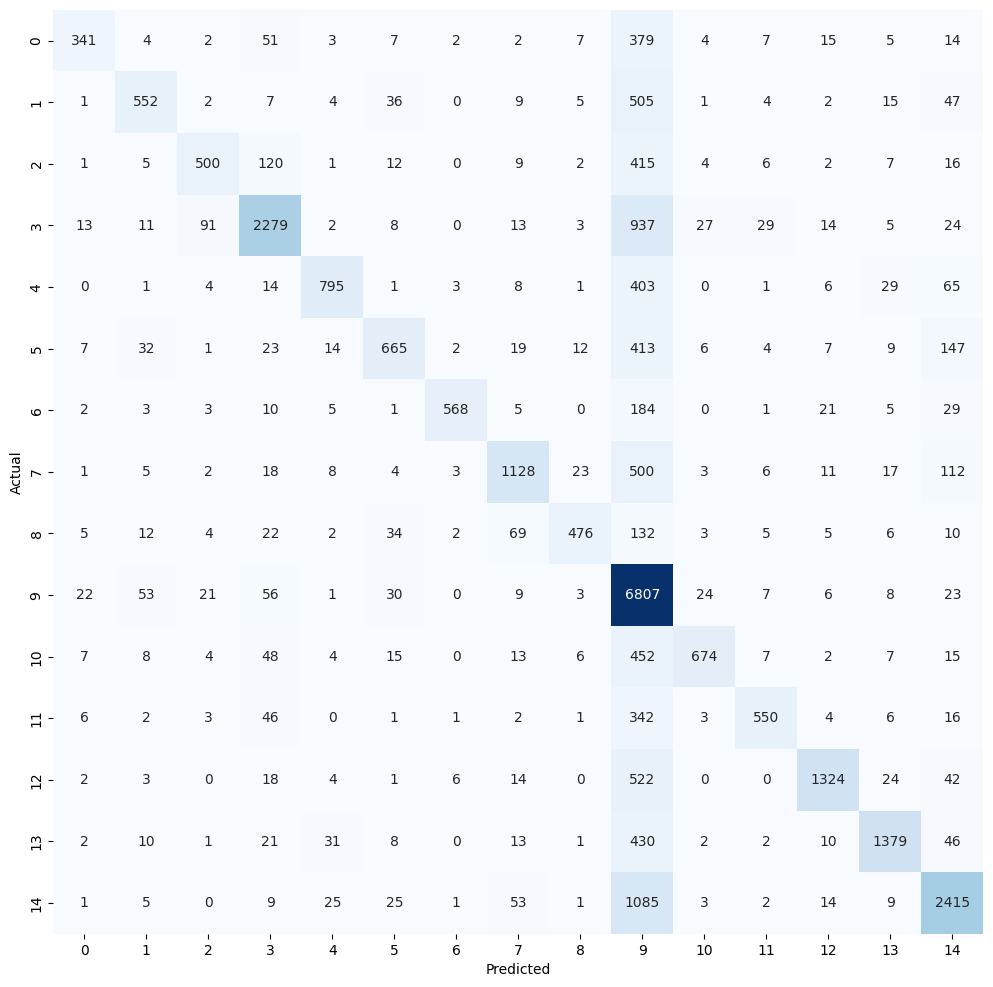

In [28]:
# Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_vec, y_train)
logistic_predictions = logistic_model.predict(X_test_vec)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)

#print confusion matrix for logistic regression model
cm = confusion_matrix(y_test, logistic_predictions)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


We can see above that the logicstic regression model gave us an overall accuracy of 0.69, which is certainly not bad, but could most likely be improved - either with a different model or with hyperparemeter tuning (tuning of the model's external configuration), shown below.

### Logistic regression hyperparameter tuning without cross-validation
In the presented code snippet below, hyperparameter tuning for logistic regression is conducted without cross-validation. 

The parameters being tuned include:
- the `regularization strength C`, which determines the inverse of regularization strength,
- the `penalty term`, representing the type of regularization applied ('l1' or 'l2') and
- the `solver`, specifying the optimization algorithm used for training the model.

The 'C' values tested range from 0.1 to 100, and both 'l1' and 'l2' penalties are explored. Additionally, two solver options, 'liblinear' and 'saga', are considered.

The code iterates through these combinations, fitting logistic regression models with specified hyperparameters to the training data. The performance metrics, including accuracy, F1 score, recall, and precision, are then recorded for each combination, forming a comprehensive evaluation of the model's behavior under various hyperparameter settings. The resulting dataframe provides insights into the impact of different configurations on the model's predictive performance.

In [29]:
param_grid = {'C': [0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']}

results = []

for C in param_grid['C']:
    for penalty in param_grid['penalty']:
        for solver in param_grid['solver']:
            
            if penalty == 'l1' and solver == 'saga':
                continue
            
            logistic_model = LogisticRegression(max_iter=1000, C=C, penalty=penalty, solver=solver)
            logistic_model.fit(X_train_vec, y_train)
            
            logistic_predictions = logistic_model.predict(X_test_vec)
            logistic_accuracy = accuracy_score(y_test, logistic_predictions)
            results.append({
                'C': C,
                'penalty': penalty,
                'solver': solver,
                'accuracy': logistic_accuracy,
                "f1_score": classification_report(y_test, logistic_predictions, output_dict=True)["weighted avg"]["f1-score"],
                "recall": classification_report(y_test, logistic_predictions, output_dict=True)["weighted avg"]["recall"],
                "precision": classification_report(y_test, logistic_predictions, output_dict=True)["weighted avg"]["precision"]
            })

results_df = pd.DataFrame(results)
results_df.sort_values(by='accuracy', ascending=False)
results_df

,C,penalty,solver,accuracy,f1_score,recall,precision
0,0.1,l1,liblinear,0.597435,0.585683,0.597435,0.692887
1,0.1,l2,liblinear,0.592945,0.565155,0.592945,0.715766
2,0.1,l2,saga,0.604962,0.581629,0.604962,0.716877
3,1.0,l1,liblinear,0.690194,0.693111,0.690194,0.762925
4,1.0,l2,liblinear,0.683139,0.683842,0.683139,0.759324
5,1.0,l2,saga,0.690464,0.692960,0.690464,0.764774
6,10.0,l1,liblinear,0.697654,0.702429,0.697654,0.765816
7,10.0,l2,liblinear,0.703122,0.707855,0.703122,0.775303
8,10.0,l2,saga,0.700759,0.705642,0.700759,0.771125
9,100.0,l1,liblinear,0.689013,0.693653,0.689013,0.753846


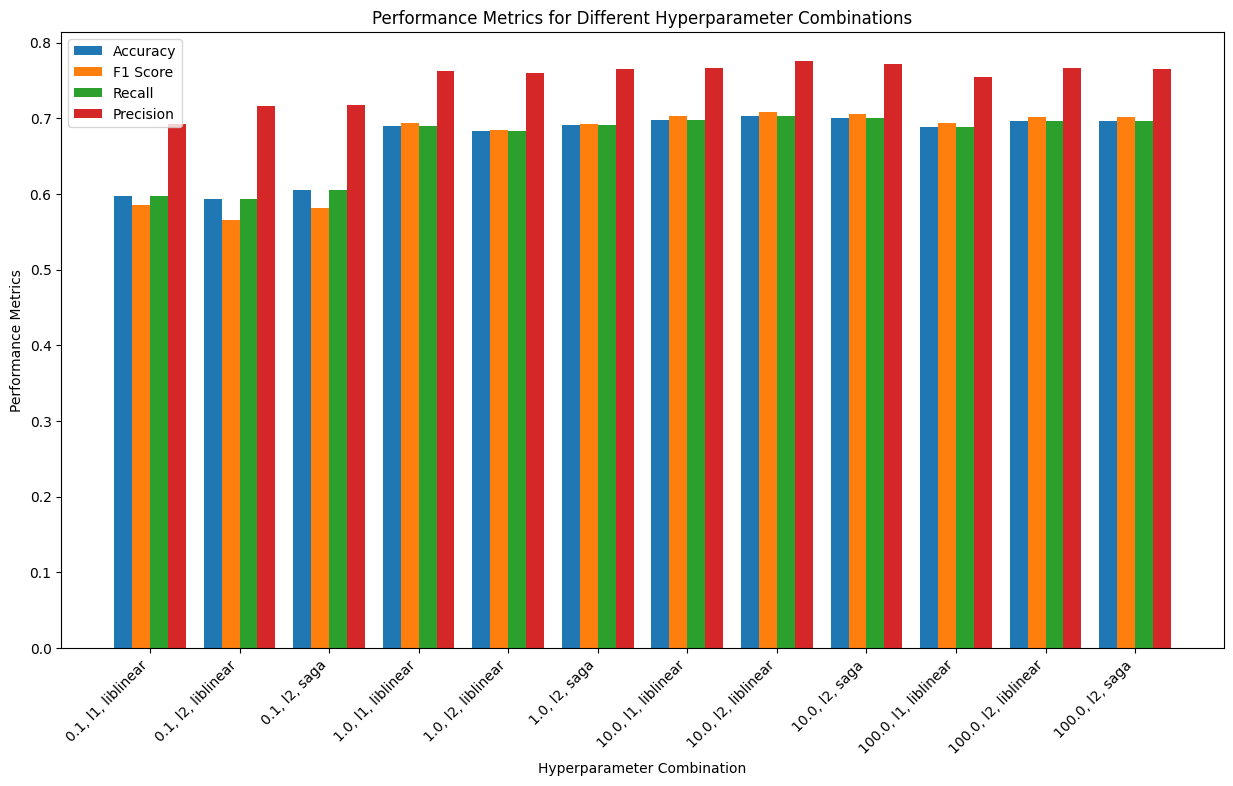

In [32]:
# Get unique hyperparameter combinations
unique_combinations = results_df[['C', 'penalty', 'solver']].drop_duplicates()

# Number of hyperparameter combinations
num_combinations = len(unique_combinations)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Set width of the bars
bar_width = 0.2

# Set positions for the bars
index = np.arange(num_combinations)

# Plot Accuracy
ax.bar(index - bar_width, results_df['accuracy'], bar_width, label='Accuracy')

# Plot F1 Score
ax.bar(index, results_df['f1_score'], bar_width, label='F1 Score')

# Plot Recall
ax.bar(index + bar_width, results_df['recall'], bar_width, label='Recall')

# Plot Precision
ax.bar(index + 2 * bar_width, results_df['precision'], bar_width, label='Precision')

# Set labels, title, and legend
ax.set_xlabel('Hyperparameter Combination')
ax.set_ylabel('Performance Metrics')
ax.set_title('Performance Metrics for Different Hyperparameter Combinations')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f"{row['C']}, {row['penalty']}, {row['solver']}" for _, row in unique_combinations.iterrows()], rotation=45, ha="right")
ax.legend()

# Show the plot
plt.show()

### Cross-validation on logistic regression model
In this analysis, we conducted cross-validation on a logistic regression model using the best-tuned hyperparameters determined earlier, which were `C = 10`, `penalty = l2` and `solver = liblinear`. 

The selected parameters were applied in a stratified K-fold cross-validation setting with `K = 5`. The model's performance metrics, including accuracy, F1 score, recall, and precision, were evaluated for each fold.

Interestingly, the results exhibited remarkable consistency across all folds, suggesting robust and stable performance of the model. 

It's noteworthy that an attempt was made to further refine the hyperparameters through an exhaustive search using cross-validation, but due to the computational intensity, the process exceeded a runtime of six hours. As a pragmatic decision, the exhaustive hyperparameter tuning was deferred in favor of the already fine-tuned logistic regression model, which had already demonstrated strong and consistent performance across different subsets of the dataset.

In [33]:
# Assuming best_params contains the best hyperparameter values
best_params = {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

# Create a Logistic Regression model with the best-tuned parameters
best_logistic_model = LogisticRegression(max_iter=1000, **best_params)

# Perform cross-validation using StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated accuracy scores
cv_accuracy_scores = cross_val_score(best_logistic_model, X_train_vec, y_train, cv=cv, scoring='accuracy')

# Get cross-validated F1 scores
cv_f1_scores = cross_val_score(best_logistic_model, X_train_vec, y_train, cv=cv, scoring='f1_weighted')

# Get cross-validated recall scores
cv_recall_scores = cross_val_score(best_logistic_model, X_train_vec, y_train, cv=cv, scoring='recall_weighted')

# Get cross-validated precision scores
cv_precision_scores = cross_val_score(best_logistic_model, X_train_vec, y_train, cv=cv, scoring='precision_weighted')

Cross-Validated Results:
   Accuracy  F1 Score    Recall  Precision
0  0.698861  0.702607  0.698861   0.770673
1  0.699958  0.703506  0.699958   0.770443
2  0.702857  0.706165  0.702857   0.771262
3  0.698553  0.701416  0.698553   0.769803
4  0.697835  0.701273  0.697835   0.768795


<Figure size 1200x800 with 0 Axes>

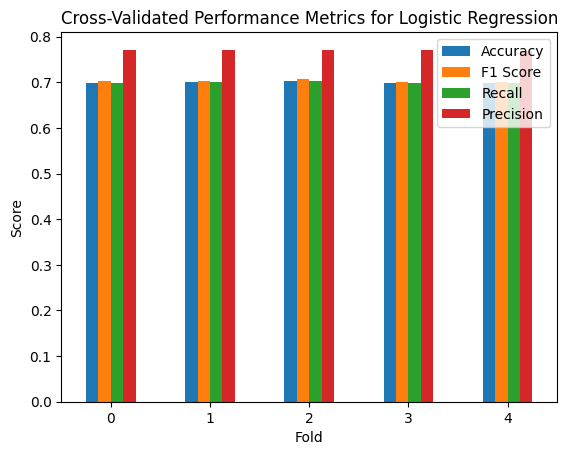

In [40]:
# Create a DataFrame with cross-validated scores
cv_results_df = pd.DataFrame({
    'Accuracy': cv_accuracy_scores,
    'F1 Score': cv_f1_scores,
    'Recall': cv_recall_scores,
    'Precision': cv_precision_scores
})

# Display the cross-validated results DataFrame
print("Cross-Validated Results:")
print(cv_results_df)

# Visualize cross-validated scores using a bar plot
plt.figure(figsize=(12, 8))
cv_results_df.plot(kind='bar', rot=0)
plt.title('Cross-Validated Performance Metrics for Logistic Regression')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.show()

# Random Forests

The random forest model is an ensemble learning algorithm widely used for both classification and regression tasks. It operates by constructing many small decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees. Each tree is constructed using a random subset of the training data, and at each node of the tree, a random subset of features is considered for splitting. This randomness and diversity among trees contribute to the robustness and generalization performance of this model.

In the provided code, a random forest model is instantiated and trained on the training dataset with certain hyperparameters. The model is configured with 200 decision trees (`n_estimators=200`), each of which requires a minimum of 2 samples at each leaf (`min_samples_leaf=2`). Additionally, bootstrapping is enabled (`bootstrap=True`), allowing random sampling with replacement, and parallel processing is utilized with all available cores (`n_jobs=-1`). The trained random forest model is then used to make predictions on the test dataset, and the accuracy of the model is evaluated. Subsequently, a confusion matrix is generated and visualized to illustrate the model's performance in classifying instances across different classes.

In [42]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,  # Reduced number of trees
    min_samples_leaf=2,  # More samples at each leaf
    bootstrap=True,   # Enable bootstrapping
    n_jobs=-1         # Use all available cores
)
rf_model.fit(X_train_vec, y_train)
rf_predictions = rf_model.predict(X_test_vec)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.6478312236286919


Our random forest initially achieved an accuracy of 0.64, which is worse than the first logistic regression model.

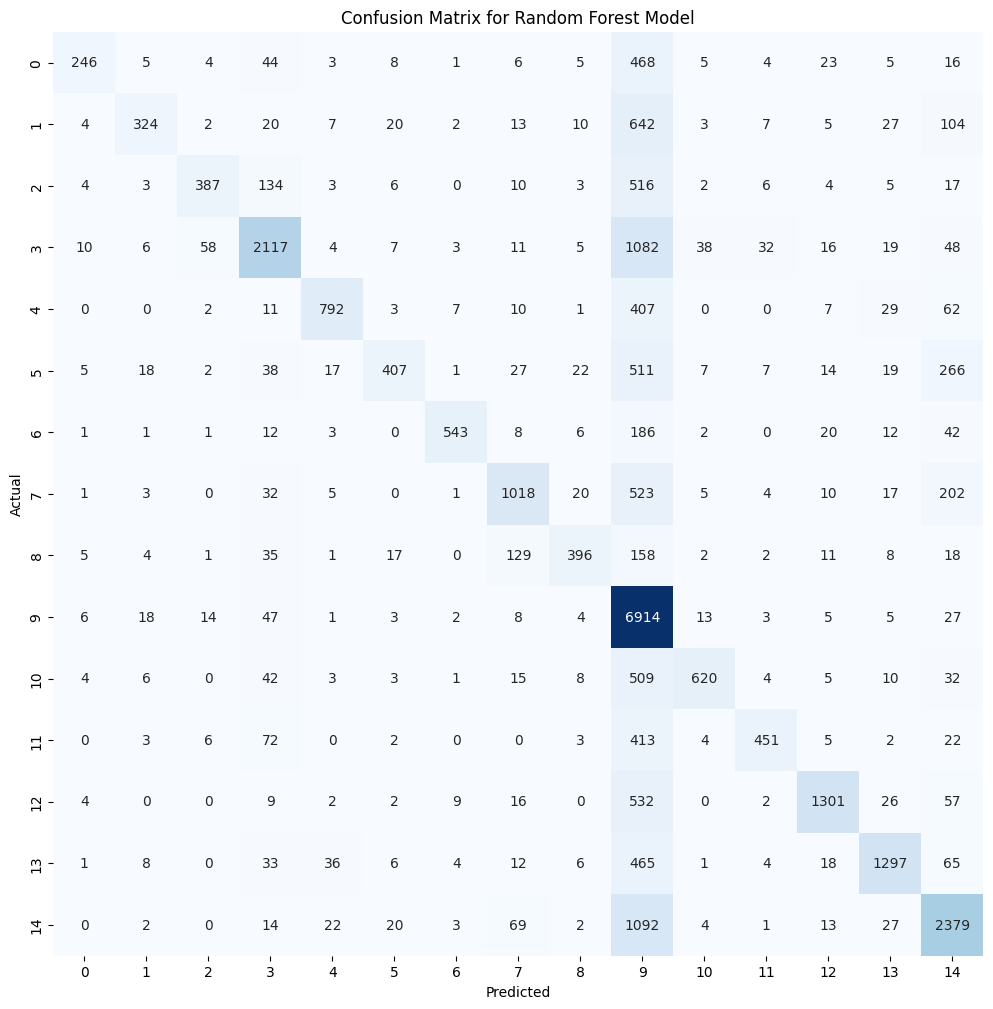

In [43]:
# Generate confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

### Hyperparameter tuning for random forest classifier without cross-validation

We conducted hyperparameter tuning for a random forest classifier without cross-validation. 

We varied:
- the number of trees in the forest (`n_estimators`) with options of 180, 200, and 220, and
- different strategies for determining the number of features at each split (`max_features`), considering both the square root and the base 2 logarithm of the total number of features.

For each hyperparameter combination, we trained a random forest model using the specified settings and assessed its performance on the test dataset. The evaluation metrics included accuracy, F1 score, precision, and recall. The results were organized into a dataframe for comprehensive analysis, with the aim of identifying the hyperparameter configuration that yielded the highest predictive accuracy on the test set.

In [45]:
# Example: Hyperparameter tuning for RandomForest without cross-validation
from sklearn.metrics import f1_score, precision_score, recall_score


rf_params = {
    'n_estimators': [180, 200, 220],
    'max_features': ["sqrt", "log2"]
}

rf_results = []

for n_estimators in rf_params['n_estimators']:
        for max_features in rf_params['max_features']:
            rf_model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=1, max_features=max_features, n_jobs=-1, bootstrap=True)
            rf_model.fit(X_train_vec, y_train)
            
            rf_predictions = rf_model.predict(X_test_vec)
            rf_accuracy = accuracy_score(y_test, rf_predictions)
            rf_results.append({
                'n_estimators': n_estimators,
                'min_samples_leaf': 1,
                "max_features": max_features,
                'accuracy': rf_accuracy,
                "f1_score": f1_score(y_test, rf_predictions, average="weighted"),
                "precision": precision_score(y_test, rf_predictions, average="weighted"),
                "recall": recall_score(y_test, rf_predictions, average="weighted"),
            })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.sort_values(by='accuracy', ascending=False)
rf_results_df

,n_estimators,min_samples_leaf,max_features,accuracy,f1_score,precision,recall
0,180,1,sqrt,0.664203,0.662385,0.749348,0.664203
1,180,1,log2,0.651679,0.644358,0.766395,0.651679
2,200,1,sqrt,0.663156,0.660901,0.747328,0.663156
3,200,1,log2,0.650160,0.641807,0.764045,0.650160
4,220,1,sqrt,0.662920,0.660794,0.747542,0.662920
5,220,1,log2,0.650802,0.643181,0.764404,0.650802


In [46]:
#print the best parameters for rf model from rf_results_df
rf_results_df.sort_values(by='accuracy', ascending=False)

,n_estimators,min_samples_leaf,max_features,accuracy,f1_score,precision,recall
0,180,1,sqrt,0.664203,0.662385,0.749348,0.664203
2,200,1,sqrt,0.663156,0.660901,0.747328,0.663156
4,220,1,sqrt,0.662920,0.660794,0.747542,0.662920
1,180,1,log2,0.651679,0.644358,0.766395,0.651679
5,220,1,log2,0.650802,0.643181,0.764404,0.650802
3,200,1,log2,0.650160,0.641807,0.764045,0.650160


In this visual analysis, we sought to explore the relationship between the number of estimators (`trees`) in a Random Forest classifier and its F1 score, considering either strategy for determining the maximum number of features at each split (`max_features`). 

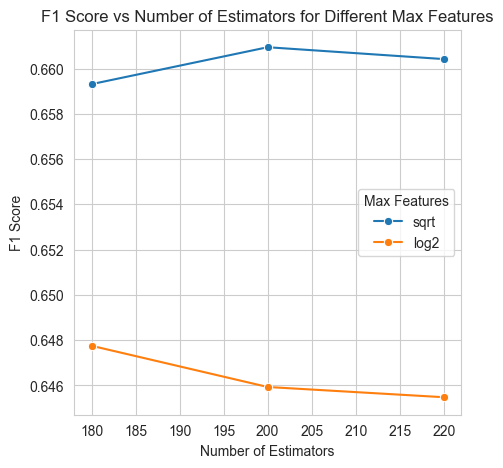

In [53]:


# Ensure max_features is of a categorical type if it isn't numeric
rf_results_df['max_features'] = rf_results_df['max_features'].astype(str)

# Creating a line plot
plt.figure(figsize=(5, 5))
sns.lineplot(x='n_estimators', y='f1_score', hue='max_features', data=rf_results_df, marker='o')

plt.title('F1 Score vs Number of Estimators for Different Max Features')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.legend(title='Max Features')
plt.show()


Upon analyzing the line plot, a notable observation emerged: as the number of estimators increased, the F1 score exhibited a decline, specifically when using the base 2 logarithm (log2) as the criterion for determining the maximum number of features at each split. 

In contrast, the F1 score remained relatively constant or experienced a slight increase when employing the square root (sqrt) strategy for max features. 

The findings suggest that, in the context of the dataset and task at hand, the logarithmic approach to feature selection became less favorable with a higher number of estimators, leading to a subsequent drop in F1 score. Conversely, the square root strategy maintained a consistent or slightly improved performance as the ensemble size increased. This behavior could be attributed to the diminishing returns of additional decision trees when relying on the logarithmic feature selection method, possibly causing the model to become overly complex or to overfit. The square root strategy, on the other hand, appears to provide a more robust and stable performance as the random forest ensemble grows in size.

## Gradient Boosting

Gradient boosting is an ensemble learning technique that combines the predictive power of multiple weak learners, often decision trees, to create a robust and accurate predictive model. The algorithm builds trees sequentially, with each subsequent tree aiming to correct the errors made by the combined ensemble of the previous ones. During training, the model assigns higher weights to instances that were misclassified by earlier trees, emphasizing their importance in subsequent iterations.

In the provided code, we applied gradient boosting to our task. First, we split the dataset into training and testing sets, and then we utilized the TF-IDF vectorizer to transform the textual features into a numerical format suitable for machine learning. The GradientBoostingClassifier was instantiated with specific hyperparameters, including
- the number of trees (`n_estimators`),
- learning rate (`learning_rate`),
- maximum depth of the trees (`max_depth`),
- minimum number of samples required at a leaf node (`min_samples_leaf`),
- maximum number of features considered for splitting (`max_features`),
- minimum number of samples required to split an internal node (`min_samples_split`),
- the subsample ratio of the training instances (`subsample`).\
The model was trained on the training set and its performance was evaluated on the test set using metrics such as accuracy, F1 score, and a detailed classification report.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=30000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

gb_classifier = GradientBoostingClassifier(n_estimators=70, learning_rate=0.2, max_depth=5, random_state=42
                                           , min_samples_leaf=50, max_features='sqrt', min_samples_split=1500, subsample=0.8)
gb_classifier.fit(X_train_vec, y_train)

# Predict and evaluate the model
predictions = gb_classifier.predict(X_test_vec)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
#get F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score:", f1)


Accuracy: 0.6071223628691983
Classification Report:
                 precision    recall  f1-score   support

  BLACK VOICES       0.76      0.33      0.46       843
      BUSINESS       0.65      0.32      0.43      1190
        COMEDY       0.76      0.37      0.50      1100
 ENTERTAINMENT       0.78      0.57      0.66      3456
  FOOD & DRINK       0.79      0.45      0.57      1331
HEALTHY LIVING       0.70      0.25      0.36      1361
 HOME & LIVING       0.89      0.61      0.72       837
     PARENTING       0.70      0.47      0.56      1841
       PARENTS       0.72      0.37      0.49       787
      POLITICS       0.46      0.95      0.62      7070
  QUEER VOICES       0.84      0.45      0.58      1262
        SPORTS       0.79      0.45      0.58       983
STYLE & BEAUTY       0.89      0.62      0.73      1960
        TRAVEL       0.82      0.62      0.70      1956
      WELLNESS       0.63      0.60      0.61      3648

      accuracy                           0.61    

This time, the accuracy before tuning was 0.61, making this our least accurate initial model.

### Hyperparameter tuning for gradient boosting classifier
In this section, we performed hyperparameter tuning for a gradient boosting classifier, aiming to optimize its performance on our task. The hyperparameters under consideration were:
- the number of trees in the ensemble (`n_estimators`),
- the learning rate controlling the contribution of each tree (`learning_rate`), and
- the maximum depth of the individual trees (`max_depth`).

For each combination of these hyperparameters, the gradient boosting model was trained on the designated training set and evaluated on the test set. As before, the evaluation metrics, including accuracy, F1 score, recall, and precision were recorded for each configuration.

In [25]:
#hyperparameter tuning for gradient boosting classifier
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [30,60,90],  # Number of trees
    'learning_rate':  [0.1, 0.15, 0.2 ],  # Learning rate
    'max_depth': [3, 5, 7]            # Maximum depth of tree
}

results_gb = []
reports_gb = []

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42,
                                                       min_samples_leaf=50, max_features='sqrt', min_samples_split=1500, subsample=0.8)
            gb_classifier.fit(X_train_vec, y_train)
            
            predictions = gb_classifier.predict(X_test_vec)
            accuracy = accuracy_score(y_test, predictions)
            results_gb.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': accuracy,
                "f1_score": f1_score(y_test, predictions, average='weighted'),
                "recall": recall_score(y_test, predictions, average='weighted'),
                "precision": precision_score(y_test, predictions, average='weighted'),
            })
    
report_gb_df = pd.DataFrame(results_gb)
report_gb_df.sort_values(by='accuracy', ascending=False)
report_gb_df


,n_estimators,learning_rate,max_depth,accuracy,f1_score,recall,precision
0,30,0.10,3,0.353316,0.293451,0.353316,0.701023
1,30,0.10,5,0.429097,0.396250,0.429097,0.690661
2,30,0.10,7,0.483848,0.462555,0.483848,0.693992
3,30,0.15,3,0.412624,0.376212,0.412624,0.637831
4,30,0.15,5,0.483544,0.462205,0.483544,0.655314
5,30,0.15,7,0.532557,0.517447,0.532557,0.667671
6,30,0.20,3,0.443004,0.414480,0.443004,0.608670
7,30,0.20,5,0.510717,0.493515,0.510717,0.638995
8,30,0.20,7,0.557468,0.545455,0.557468,0.653983
9,60,0.10,3,0.472810,0.448822,0.472810,0.697190


In [54]:
#sort the results by f1 score
report_gb_df.sort_values(by='f1_score', ascending=False).head(5)

,n_estimators,learning_rate,max_depth,accuracy,f1_score,recall,precision
20,150,0.18,30,0.684118,0.687201,0.684118,0.750467
11,120,0.18,30,0.682464,0.685084,0.682464,0.748119
14,120,0.22,30,0.681958,0.684462,0.681958,0.747168
23,150,0.22,30,0.681519,0.684218,0.681519,0.746426
26,150,0.30,30,0.680574,0.683100,0.680574,0.744076


Following our initial hyperparameter tuning for the gradient boosting classifier, we observed that increasing the number of trees (`n_estimators`) had a more pronounced positive impact on model performance compared to adjusting the learning rate (`learning_rate`). Additionally, a higher maximum depth of the individual trees (`max_depth`) seemed to have a more significant influence on improving results.

Encouraged by these insights, we conducted further experiments by maintaining a relatively high learning rate, specifically 0.18, 0.2, and 0.25, while concurrently increasing both the number of trees and the maximum depth. A comprehensive grid search was conducted, evaluating the model's accuracy, F1 score, recall, and precision for various combinations of these hyperparameters. We tested three values for each hyperparameter - 90, 120, and 150 trees, learning rates of 0.18, 0.22, and 0.3, and maximum tree depths of 7, 15, and 30.

In [29]:
param_grid = {
    'n_estimators': [90, 120, 150],  # Number of trees
    'learning_rate':  [0.18, 0.22, 0.3 ],  # Learning rate
    'max_depth': [7, 15, 30]            # Maximum depth of tree
}

results_gb = []
reports_gb = []

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42,
                                                       min_samples_leaf=50, max_features='sqrt', min_samples_split=1500, subsample=0.8)
            gb_classifier.fit(X_train_vec, y_train)
            
            predictions = gb_classifier.predict(X_test_vec)
            accuracy = accuracy_score(y_test, predictions)
            results_gb.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'accuracy': accuracy,
                "f1_score": f1_score(y_test, predictions, average='weighted'),
                "recall": recall_score(y_test, predictions, average='weighted'),
                "precision": precision_score(y_test, predictions, average='weighted'),
            })
    
report_gb_df = pd.DataFrame(results_gb)
report_gb_df.sort_values(by='accuracy', ascending=False)
report_gb_df


,n_estimators,learning_rate,max_depth,accuracy,f1_score,recall,precision
0,90,0.18,7,0.638110,0.634314,0.638110,0.707688
1,90,0.18,15,0.666194,0.666179,0.666194,0.731841
2,90,0.18,30,0.678481,0.680447,0.678481,0.743953
3,90,0.22,7,0.641789,0.638761,0.641789,0.706684
4,90,0.22,15,0.669300,0.669757,0.669300,0.733167
5,90,0.22,30,0.679224,0.681336,0.679224,0.744601
6,90,0.30,7,0.648304,0.646329,0.648304,0.707964
7,90,0.30,15,0.670346,0.671202,0.670346,0.731847
8,90,0.30,30,0.678245,0.680501,0.678245,0.741561
9,120,0.18,7,0.650397,0.648502,0.650397,0.717533


In this visualization analysis, we sought to understand the interaction between the three tested hyperparameters of the gradient boosting classifier.

We utilized a series of heatmaps to showcase the F1 score performance for different combinations of learning rates and the number of estimators, with each heatmap representing a distinct maximum tree depth.

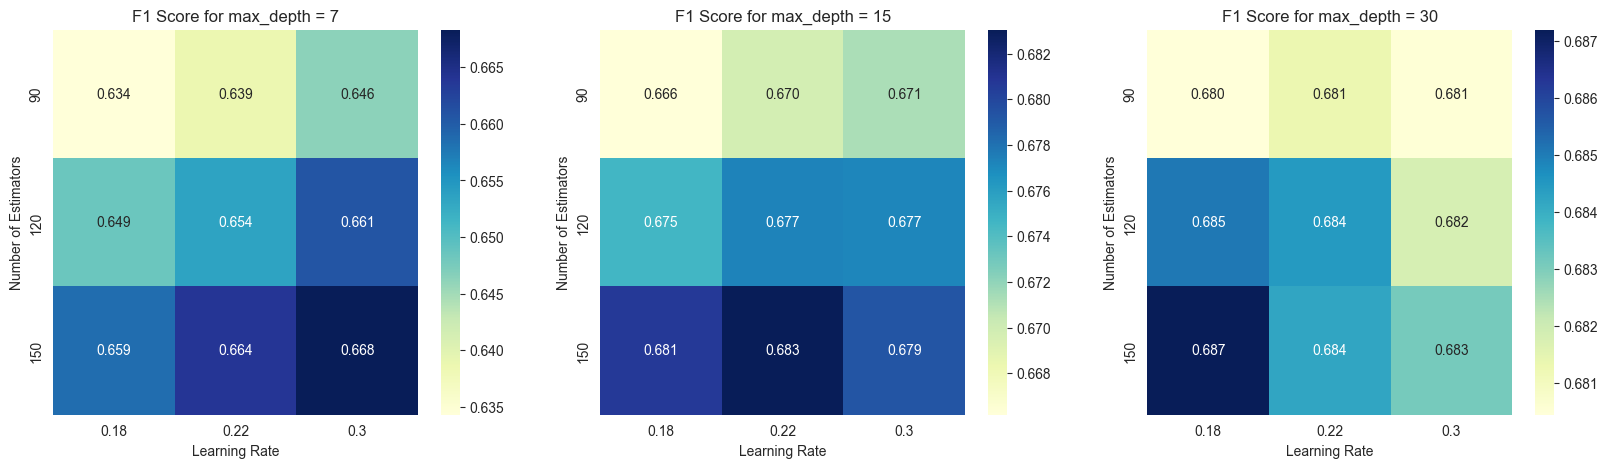

In [51]:
max_depth_values = report_gb_df['max_depth'].unique()
plt.figure(figsize=(20,5))
idx = 1
# Creating a series of heatmaps
for depth in max_depth_values:
    # Filter the DataFrame for the current value of max_depth
    temp_report_gb_df = report_gb_df[report_gb_df['max_depth'] == depth]

    # Pivot the DataFrame to create a matrix suitable for heatmap
    pivot_df = temp_report_gb_df.pivot(index='n_estimators', columns='learning_rate', values='f1_score')

    # Create the heatmap
    plt.subplot(1, 3, idx)
    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f'F1 Score for max_depth = {depth}')
    plt.ylabel('Number of Estimators')
    plt.xlabel('Learning Rate')
    idx += 1

plt.show()




The visual analysis of the Gradient Boosting Classifier's hyperparameter tuning revealed a prominent influence of the number of estimators on model accuracy. Notably, as the number of trees in the ensemble (n_estimators) increased, the accuracy consistently demonstrated an upward trend, reaching its highest value when set to 150 estimators. This observation suggests that a larger ensemble of trees contributes significantly to improving the classifier's accuracy on the text classification task.\
It is also perhaps notable that while the number of estimators always positively impacted our model, as maximum tree depth increased, the learning rate should decrease for our measured F1 score to continue improving.

The model achieved this best performance with 150 estimators, a learning rate of 0.18, and a maximum tree depth of 30. The associated metrics for this configuration include an accuracy of 68.41%, an F1 score of 68.72%, recall of 68.41%, and precision of 75.05%.

In [37]:
best_report_gb_df = report_gb_df.sort_values(by='f1_score', ascending=False).head(1)
(best_report_gb_df)


,n_estimators,learning_rate,max_depth,accuracy,f1_score,recall,precision
20,150,0.18,30,0.684118,0.687201,0.684118,0.750467


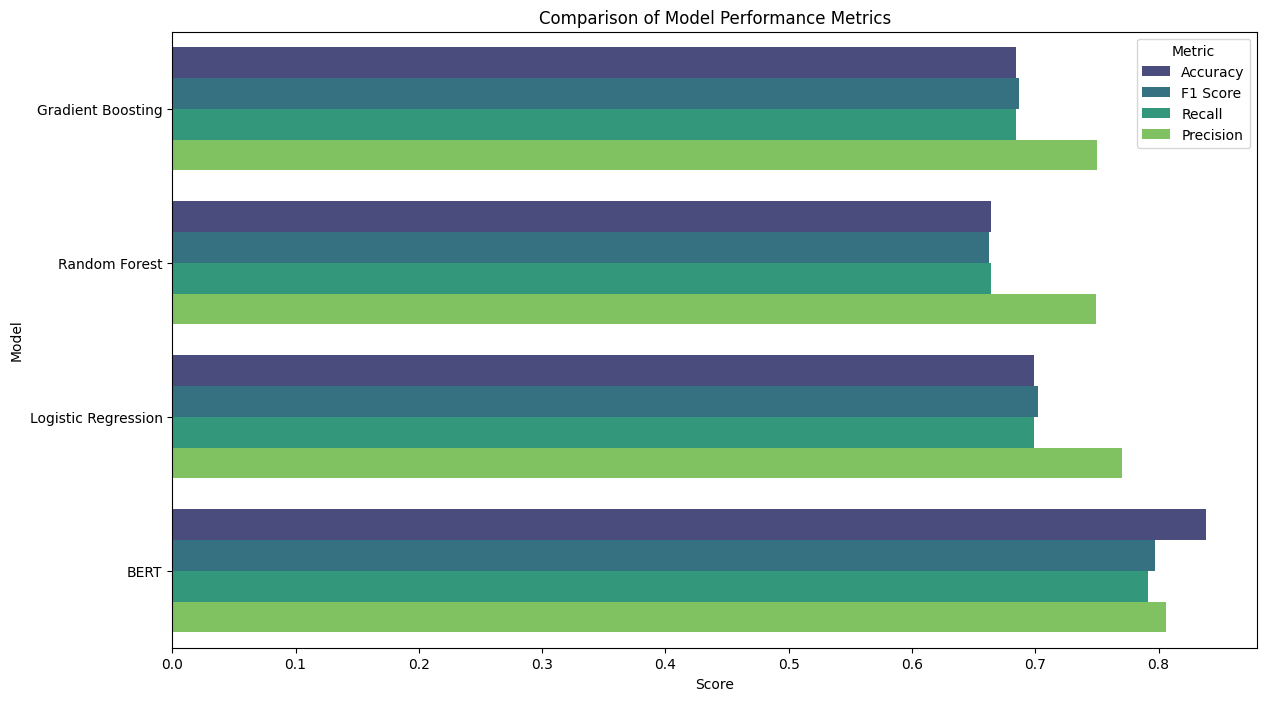

In [48]:
# Define the data
models = ['Gradient Boosting', 'Random Forest', 'Logistic Regression', 'BERT']
accuracy = [0.684118, 0.664203, 0.698861, 0.8382]
f1_score = [0.687201, 0.662385, 0.702607, 0.7971966493925249]
recall = [0.684118, 0.664203, 0.698861, 0.7914781246120076]
precision = [0.750467, 0.749348, 0.770673, 0.8062456684035972]

# Create a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_score,
    'Recall': recall,
    'Precision': precision
})

# Melt the DataFrame for better plotting
comparison_df_melted = pd.melt(comparison_df, id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Score', y='Model', hue='Metric', data=comparison_df_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics')
plt.xlabel('Score')
plt.ylabel('Model')
plt.show()


The BERT model outperforms traditional machine learning models, including gradient boosting, random forest, and logistic regression, as indicated by its superior evaluation metrics. 

With an accuracy of 83.82%, BERT exhibits a notable advantage over the other models in accurately classifying instances in the text classification task. The precision of 80.62% underscores its ability to correctly identify positive instances, while the recall of 79.15% highlights its effectiveness in capturing all relevant instances. Furthermore, the F1 score of 79.72% strikes a balanced chord between precision and recall, signifying BERT's robustness in achieving accurate and comprehensive predictions.\
BERT's exceptional performance can be attributed to its pre-trained contextualized embeddings, capturing intricate contextual nuances in language, enabling more nuanced understanding and representation of the given text data compared to traditional machine learning models. The comprehensive evaluation metrics collectively affirm BERT's superiority in handling the complexities of the text classification task, showcasing the transformative impact of pre-trained language models in natural language processing tasks.

As for our own models, this chart shows us that logistic regression performed the best in every metric, while random forests, despite their reputation as a strong model, do not perform as well on this task. However, the differences in metrics between our three models are slight enough that they can likely be surpassed with better parameters and more training.